In [1]:
library(tidyverse)
library(ggplot2)

library(openair)

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
suppressMessages(library(doMC))
registerDoMC(cores=as.integer(detectCores()*0.75))

In [3]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [4]:
setwd("~/Repositories/AirQualityCOVID/")

In [5]:
method <- "knn"

load(paste("data/Cross-validation/cross_val/", method, ".rda", sep=""))

# Metricas

In [6]:
pivot.metrics <- cross.val$metrics %>%
        pivot_longer(cols = 7:ncol(cross.val$metrics),
                     names_to = "Error", values_to = "Err.Val")

In [7]:
dat.df <- pivot.metrics %>%
            filter(
                days %in% c(
                            0,
                            1,
                            2,
                            3
                            ),
                site %in% c(
                            "es0118a", 
                            "es1580a", 
                            "es1340a", 
                            "es1438a"
                            ),
                variable %in% c(
                                "no", 
                                "no2", 
                                "o3", 
                                "pm10", 
                                "pm2.5"
                                ),
                year %in% c(
                            2013,
                            2014, 
                            2015, 
                            2016, 
                            2017, 
                            2018, 
                            2019
                            ),
                param %in% c(
                             # k-NN
                             1,
                             2,
                             3,
                             4,
                             5,
                             6,
                             7,
                             8,
                             9, 
                             10,
                             # randomForest
                             10, 
                             20, 
                             30, 
                             50, 
                             100, 
                             150, 
                             200
                             ),
                qq.Mapping %in% c(
                                  "Yes",
                                  "No"
                                  ),
                Error %in% c(
                             "Bias", 
                             "cor1", 
                             "cor2", 
                             "var.ratio", 
                             "RMSE"
                             )
            )

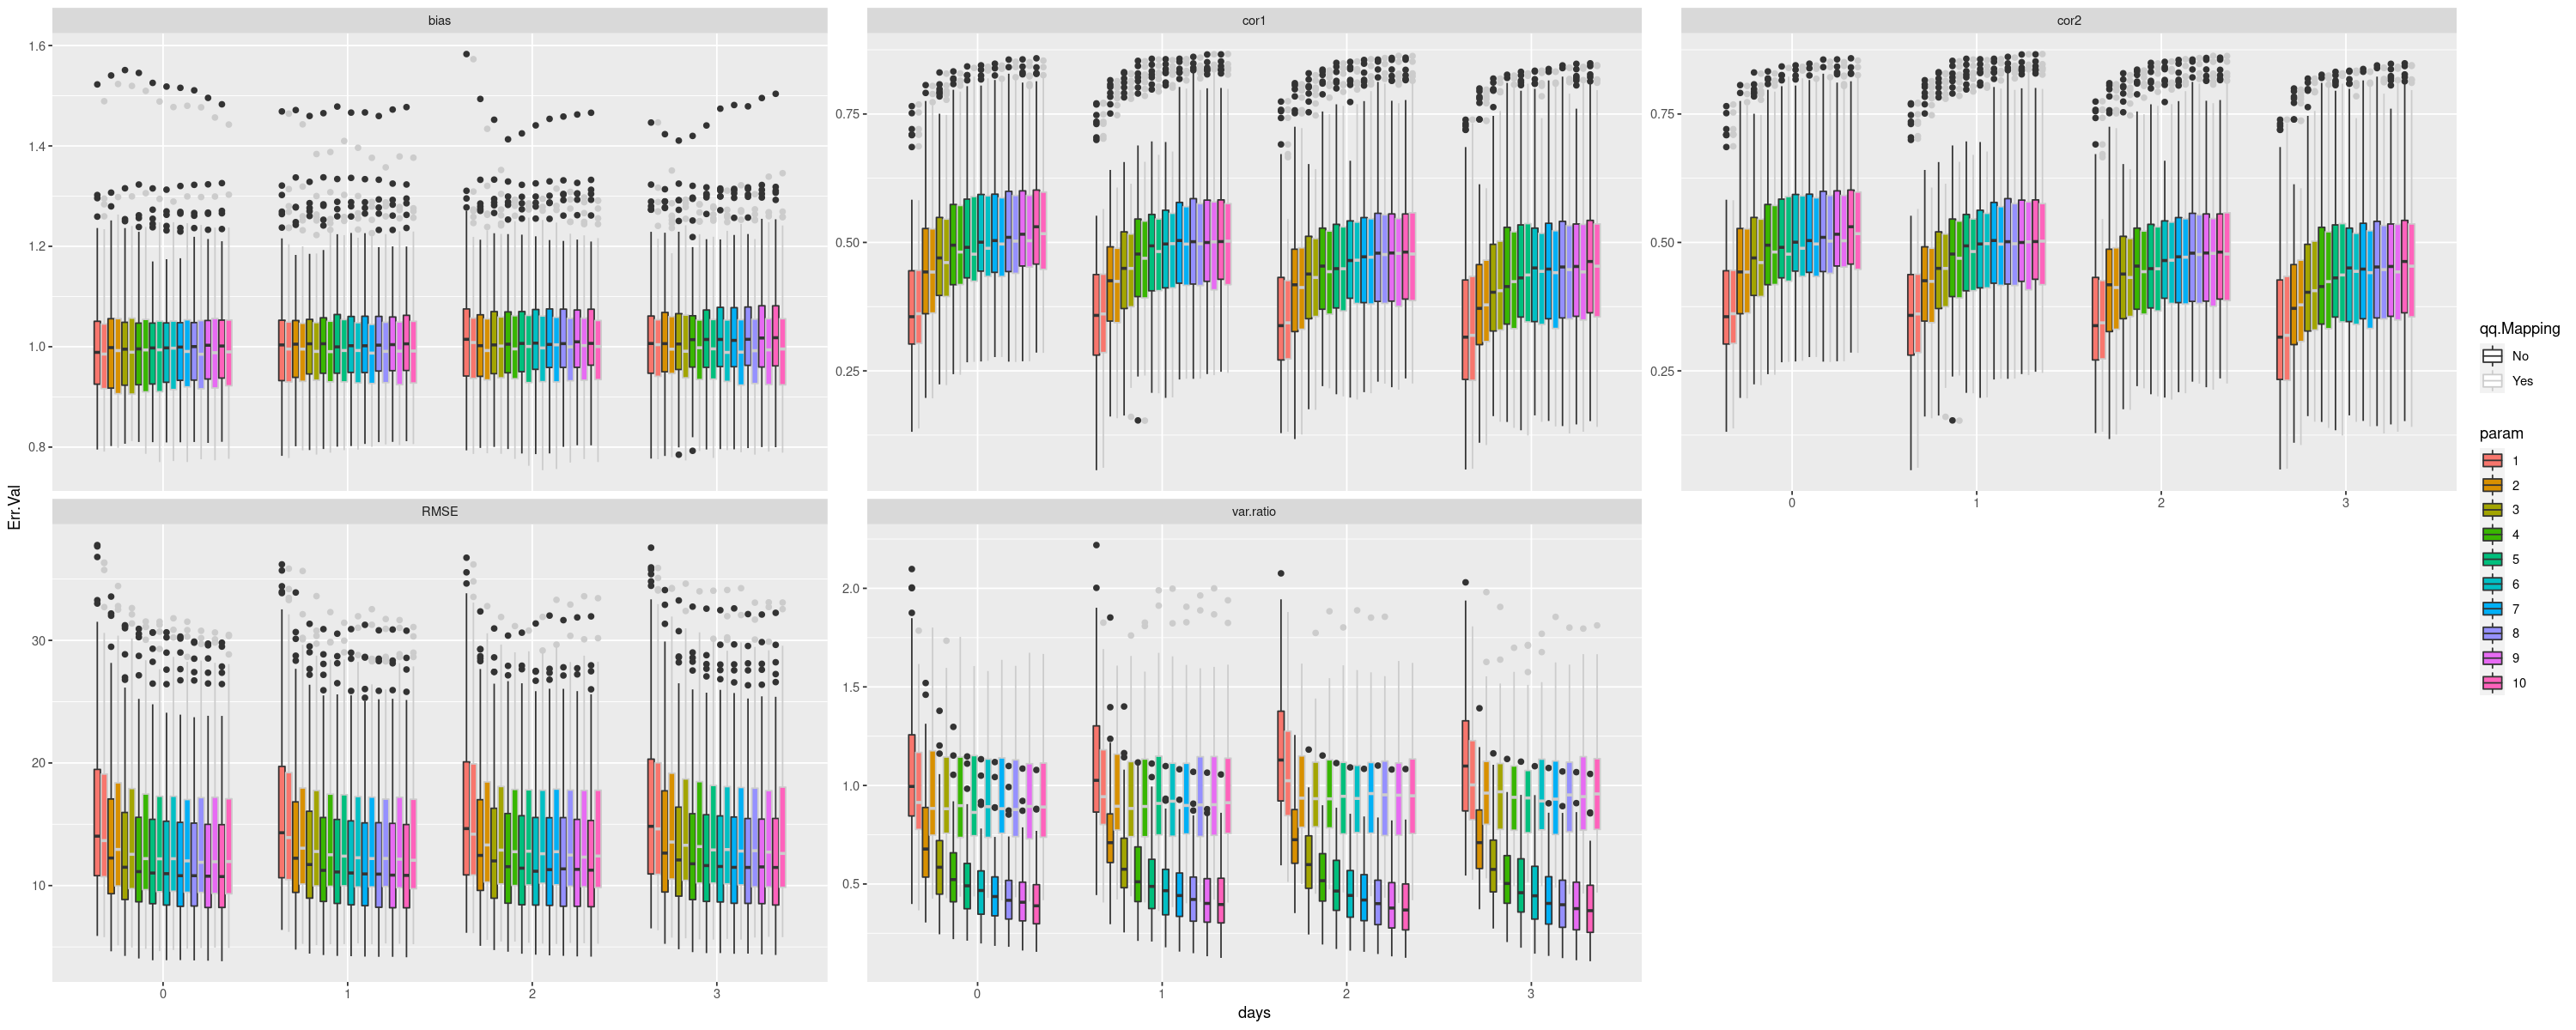

In [8]:
ggplot(data=pivot.metrics) +
    geom_boxplot(aes(x=days, y=Err.Val, fill=param, color=qq.Mapping)) +
    scale_color_grey() +
    facet_wrap(~Error,scale="free_y")

# Predicciones

In [9]:
predict.df <- cross.val$predictions %>%
            filter(
                days %in% c(
                            0
                            ,1
                            #,2
                            #,3
                            ),
                site %in% c(
                            "es0118a", 
                            "es1580a", 
                            "es1340a", 
                            "es1438a"
                            ),
                variable %in% c(
                                "no", 
                                "no2", 
                                "o3", 
                                "pm10", 
                                "pm2.5"
                                ),
                year %in% c(
                            2013,
                            2014, 
                            2015, 
                            2016, 
                            2017, 
                            2018, 
                            2019
                            ),
                param %in% c(
                             # k-NN
                             #1,
                             #2,
                             #3,
                             4,
                             5,
                             #6,
                             #7,
                             #8,
                             #9, 
                             #10,
                             # randomForest
                             #10, 
                             20, 
                             30, 
                             50, 
                             100, 
                             150, 
                             200
                             )
            )

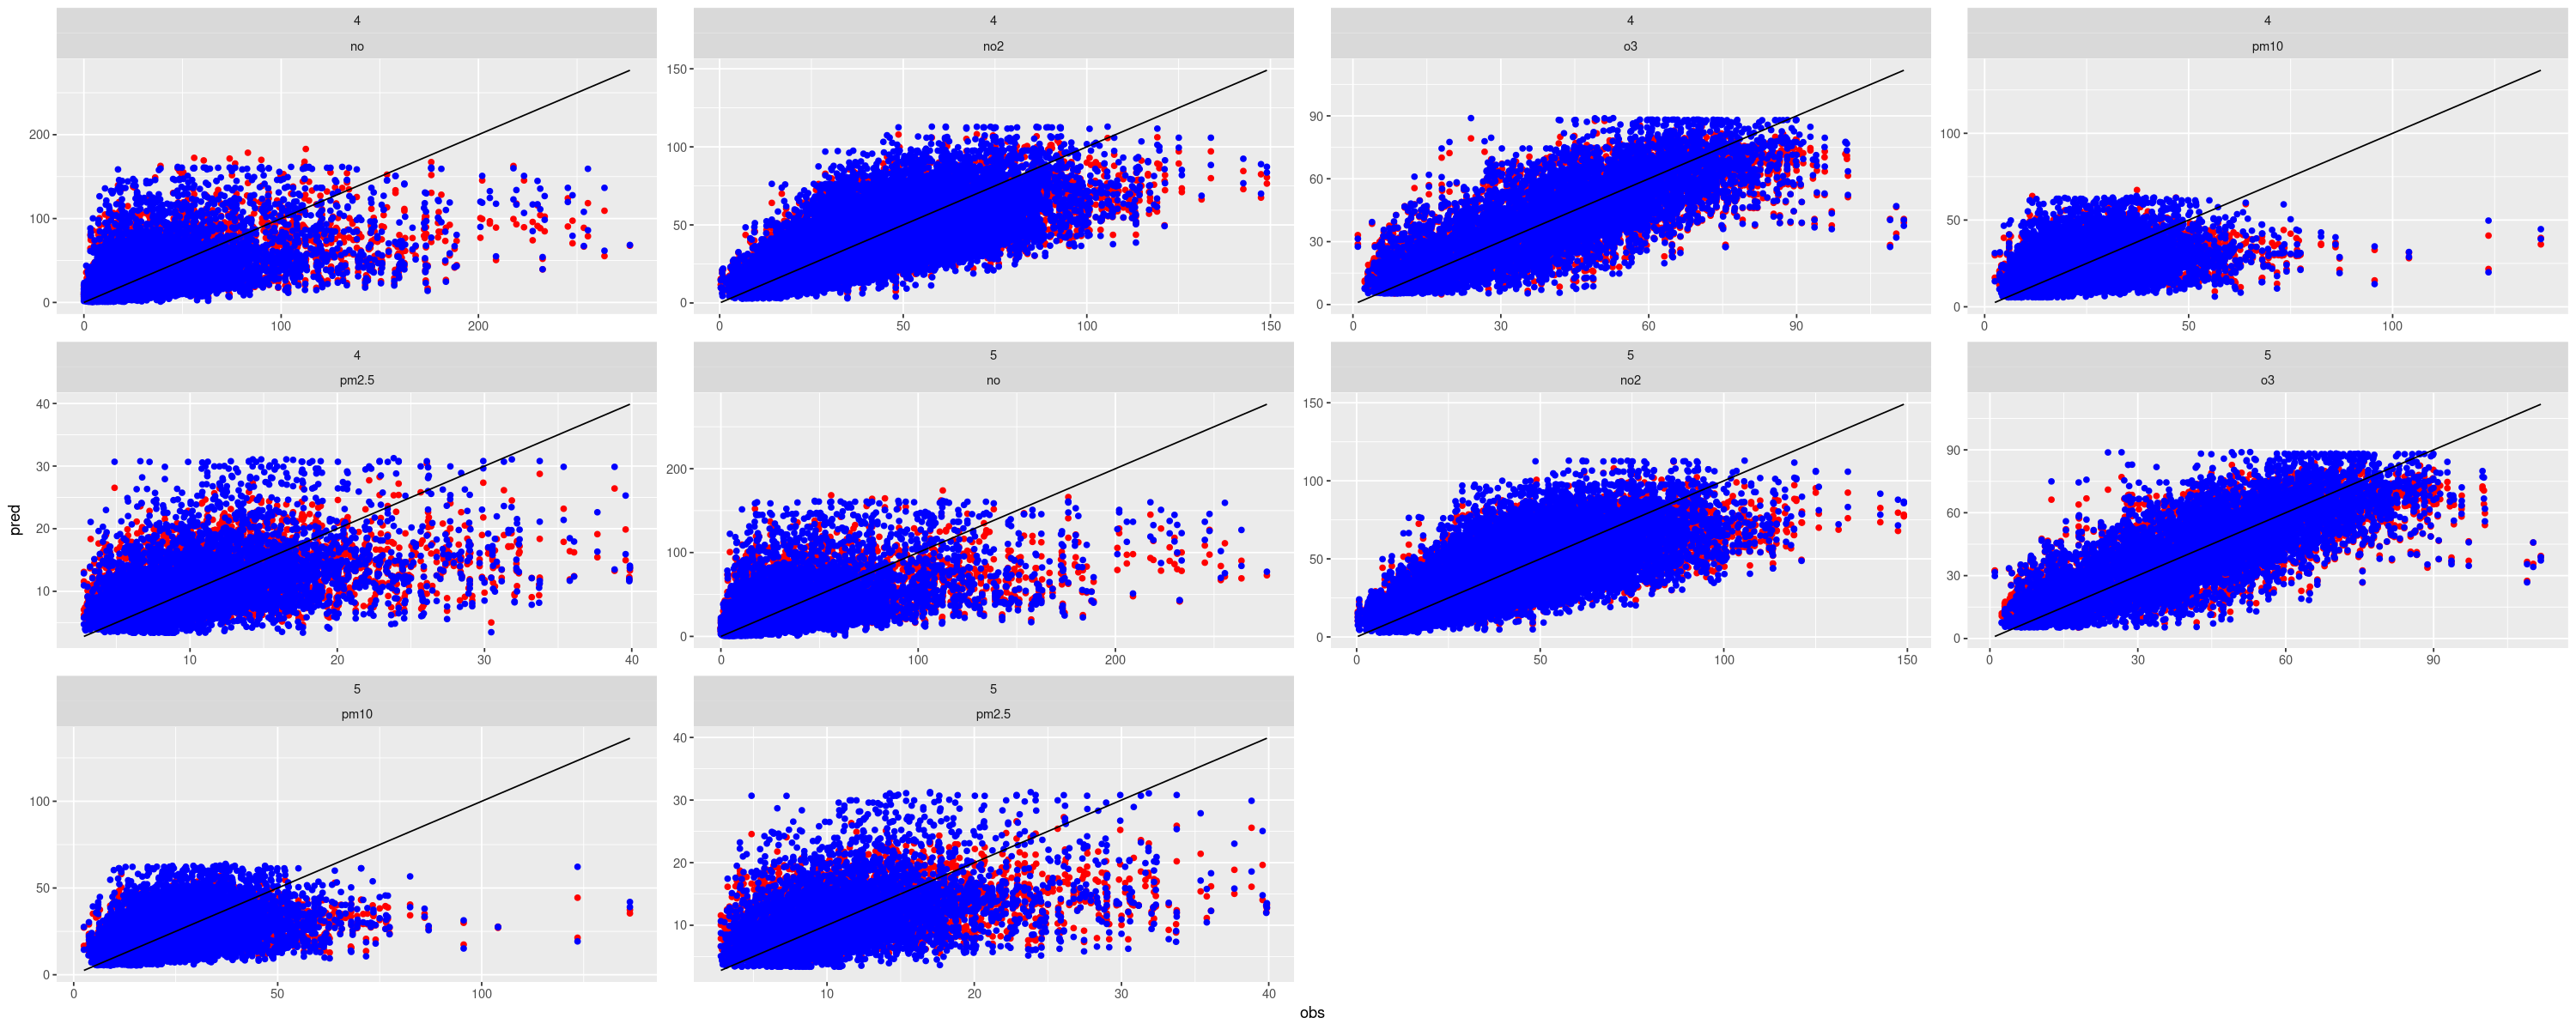

In [10]:
ggplot(data=predict.df) +
        geom_point(aes(x=obs, y=pred), color = "red") +
        geom_point(aes(x=obs, y=pred.qq), color = "blue") +
        geom_line(aes(x=obs, y=obs), color = "black") +
        facet_wrap(~param+variable, scale="free")

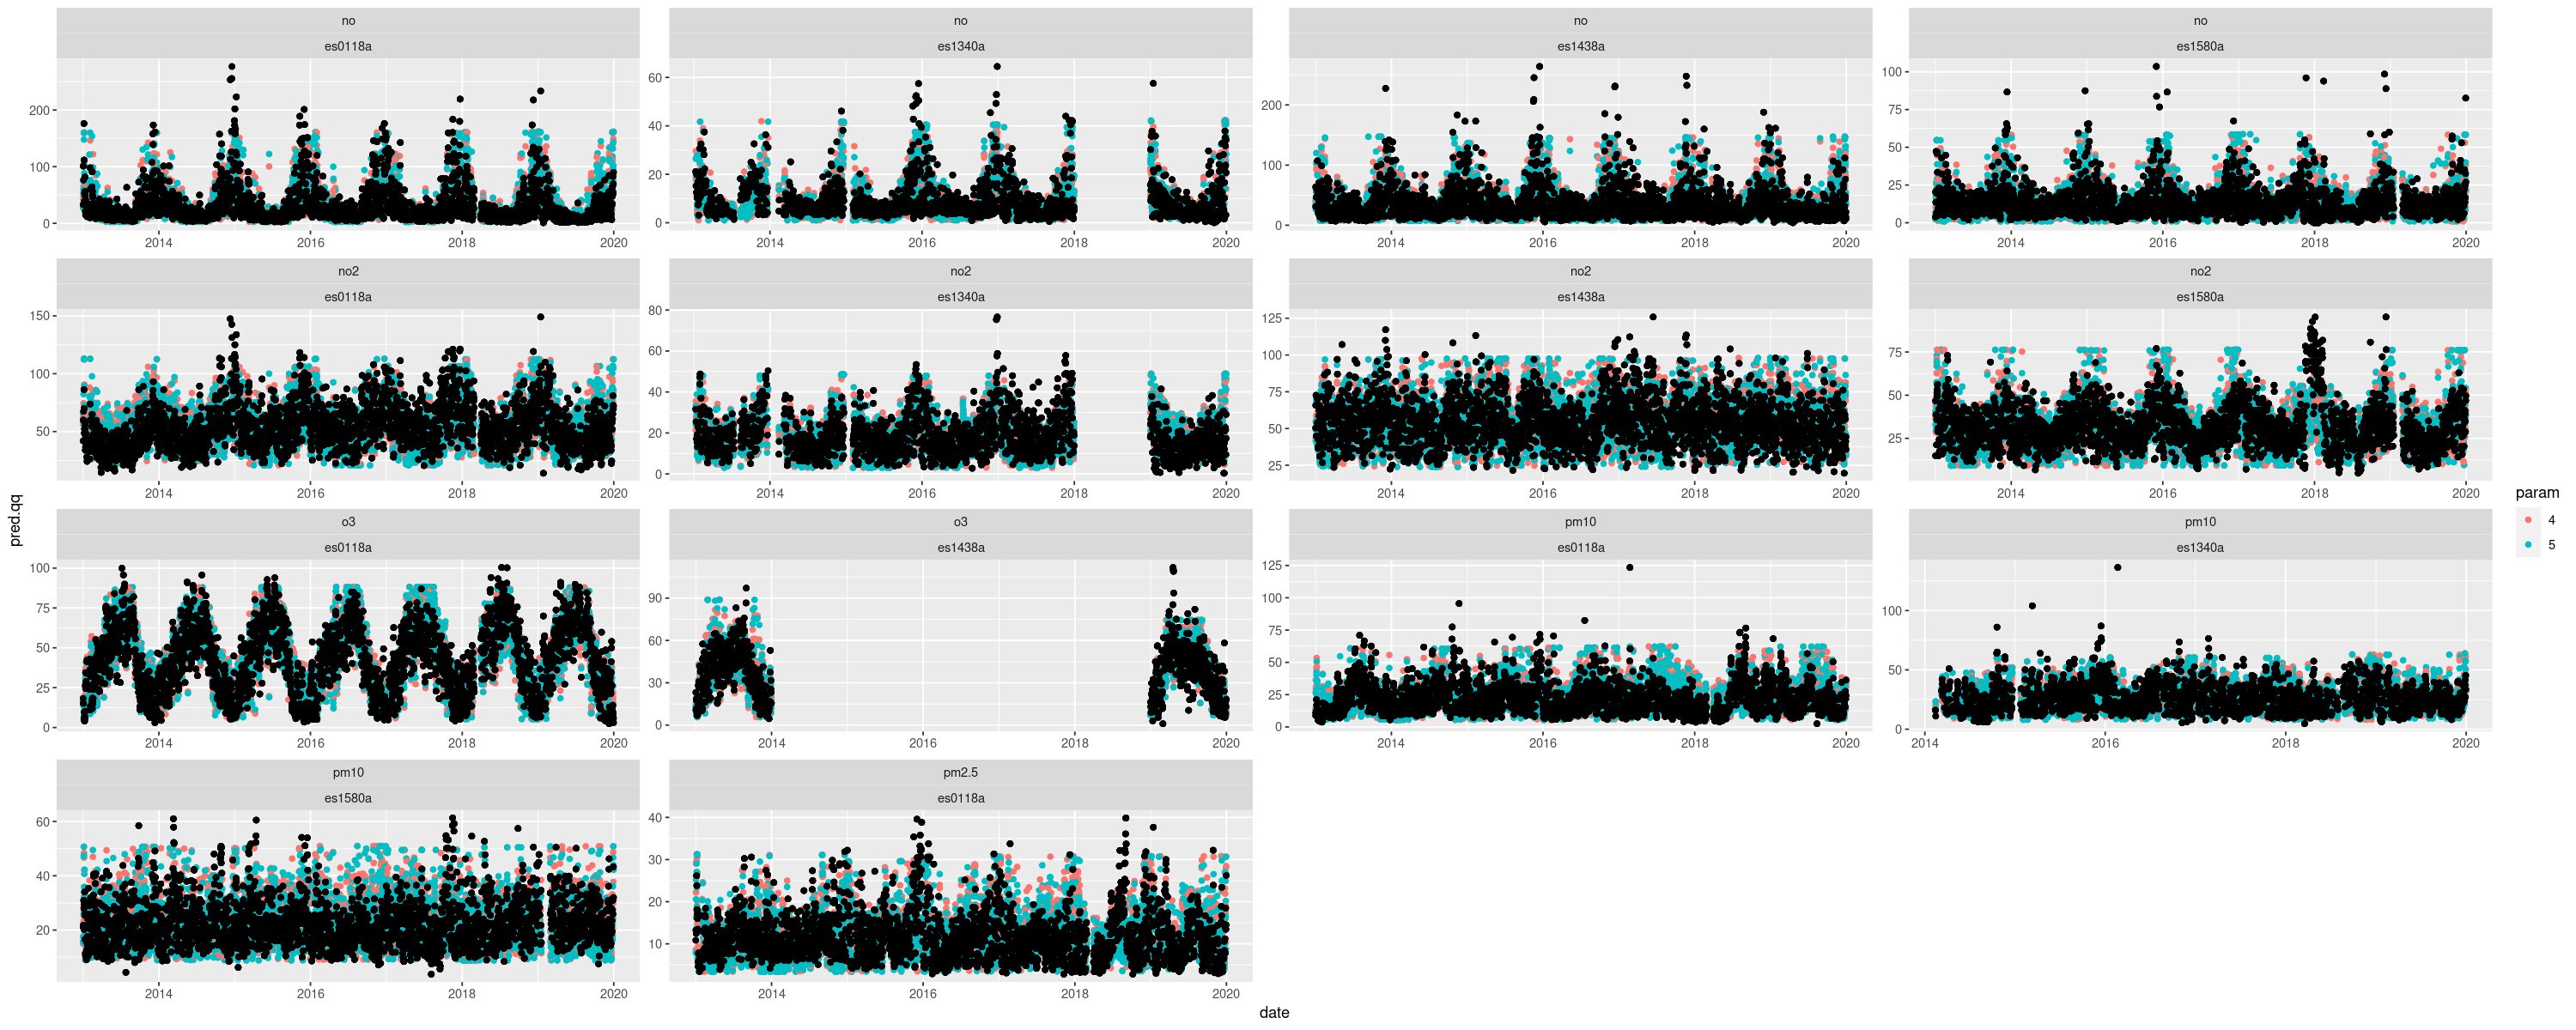

In [11]:
ggplot(data=predict.df) +
    geom_point(aes(x=date, y=pred.qq, color = param)) +
    geom_point(aes(x=date, y=obs), color = "black") +
    facet_wrap(~variable+site, scale="free", ncol=4)

In [12]:
test <- predict.df %>%
            rename(value = pred.qq) %>%
            timeAverage(avg.time = "2 week", 
                        type = c("days", "site", "variable", "param"))

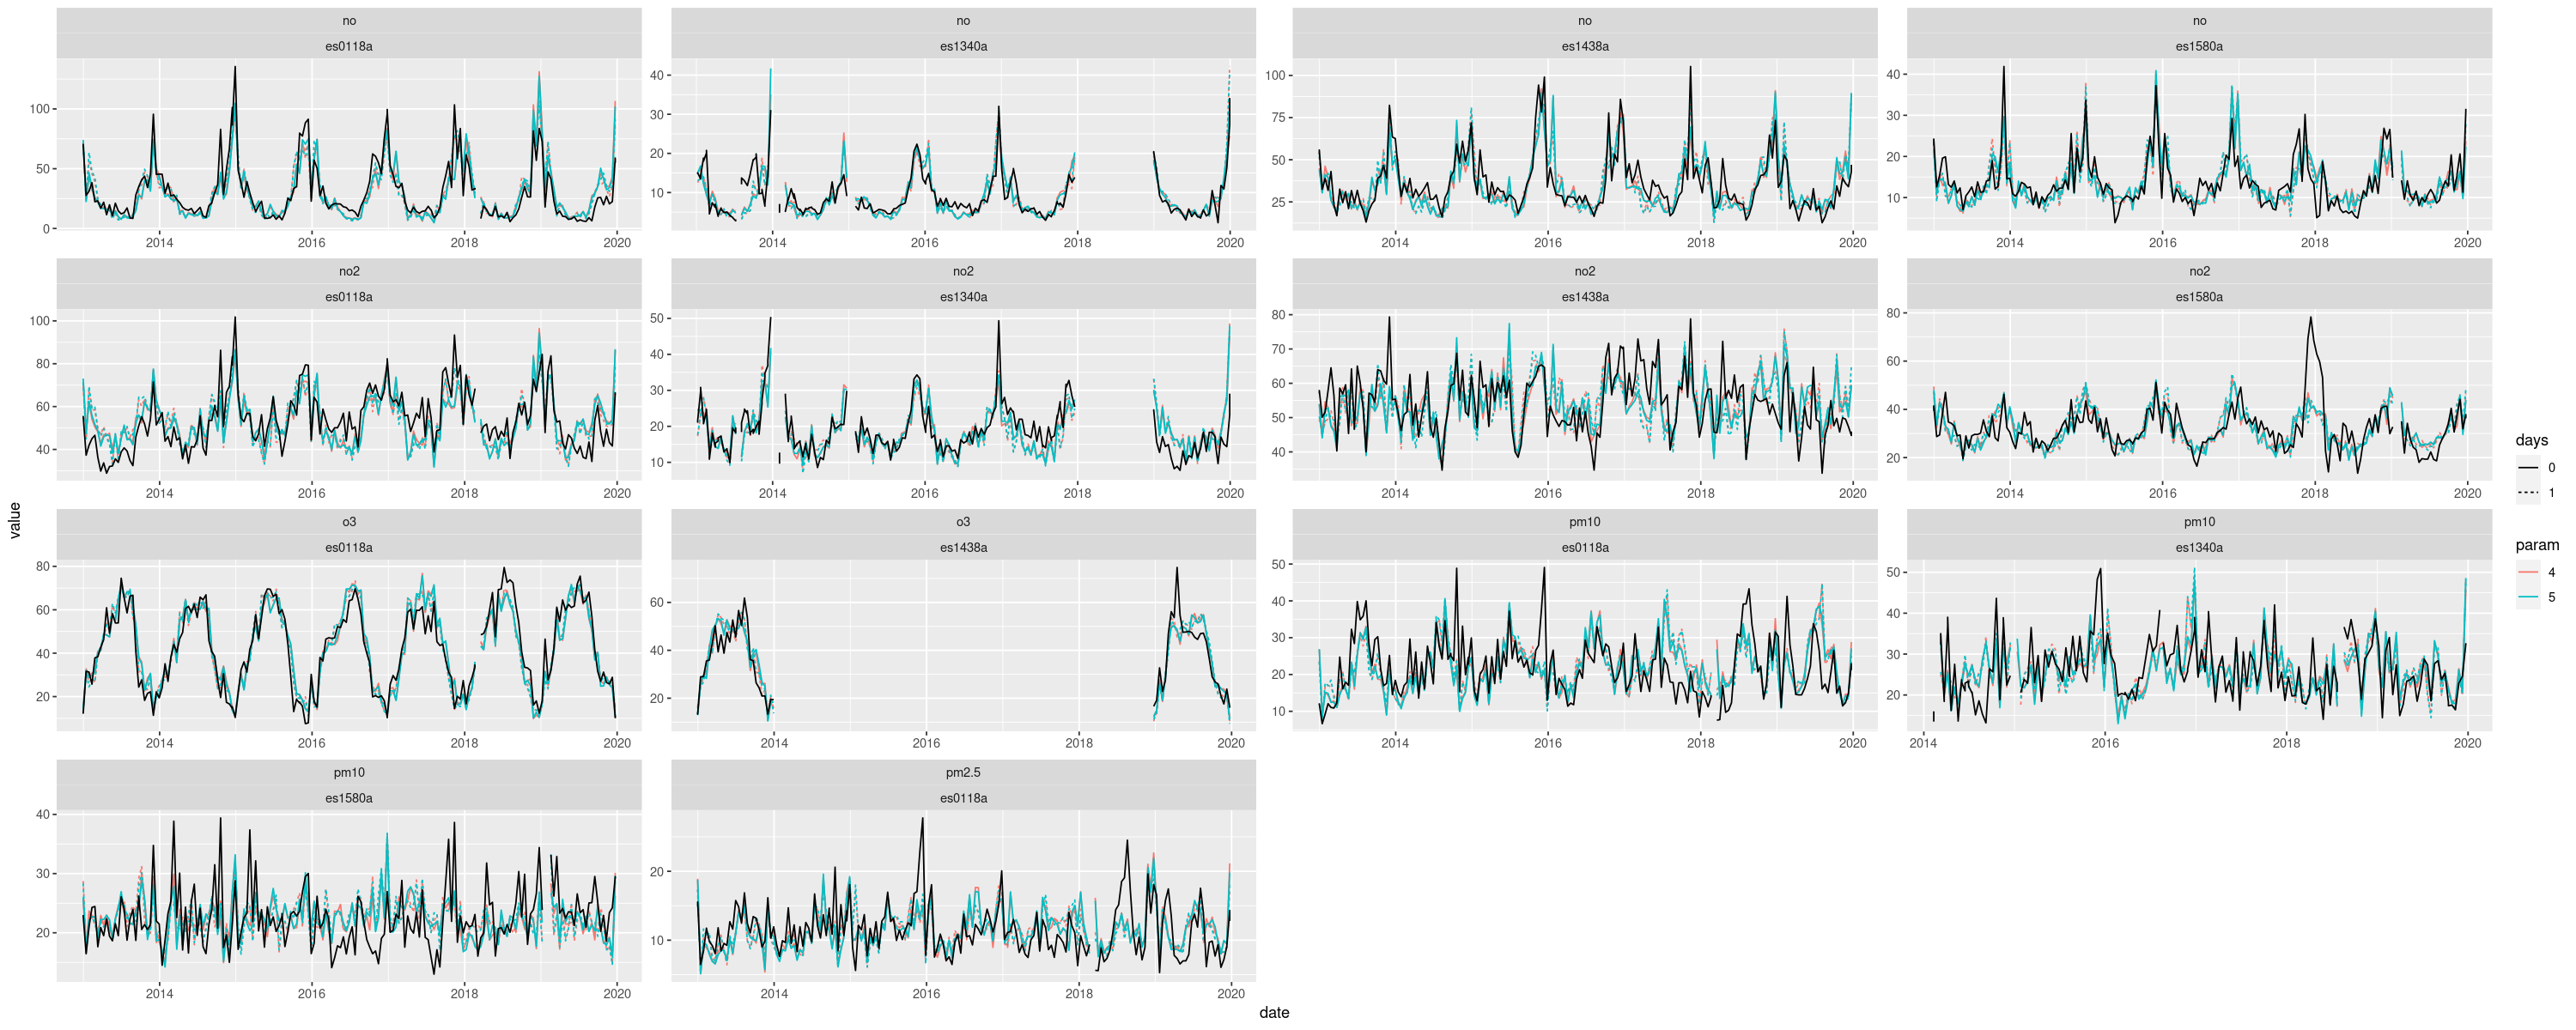

In [13]:
ggplot(data=test) +
    geom_line(aes(x=date, y=value, color = param, linetype=days)) +
    geom_line(aes(x=date, y=obs), color = "black") +
    facet_wrap(~variable+site, scale="free", ncol=4)

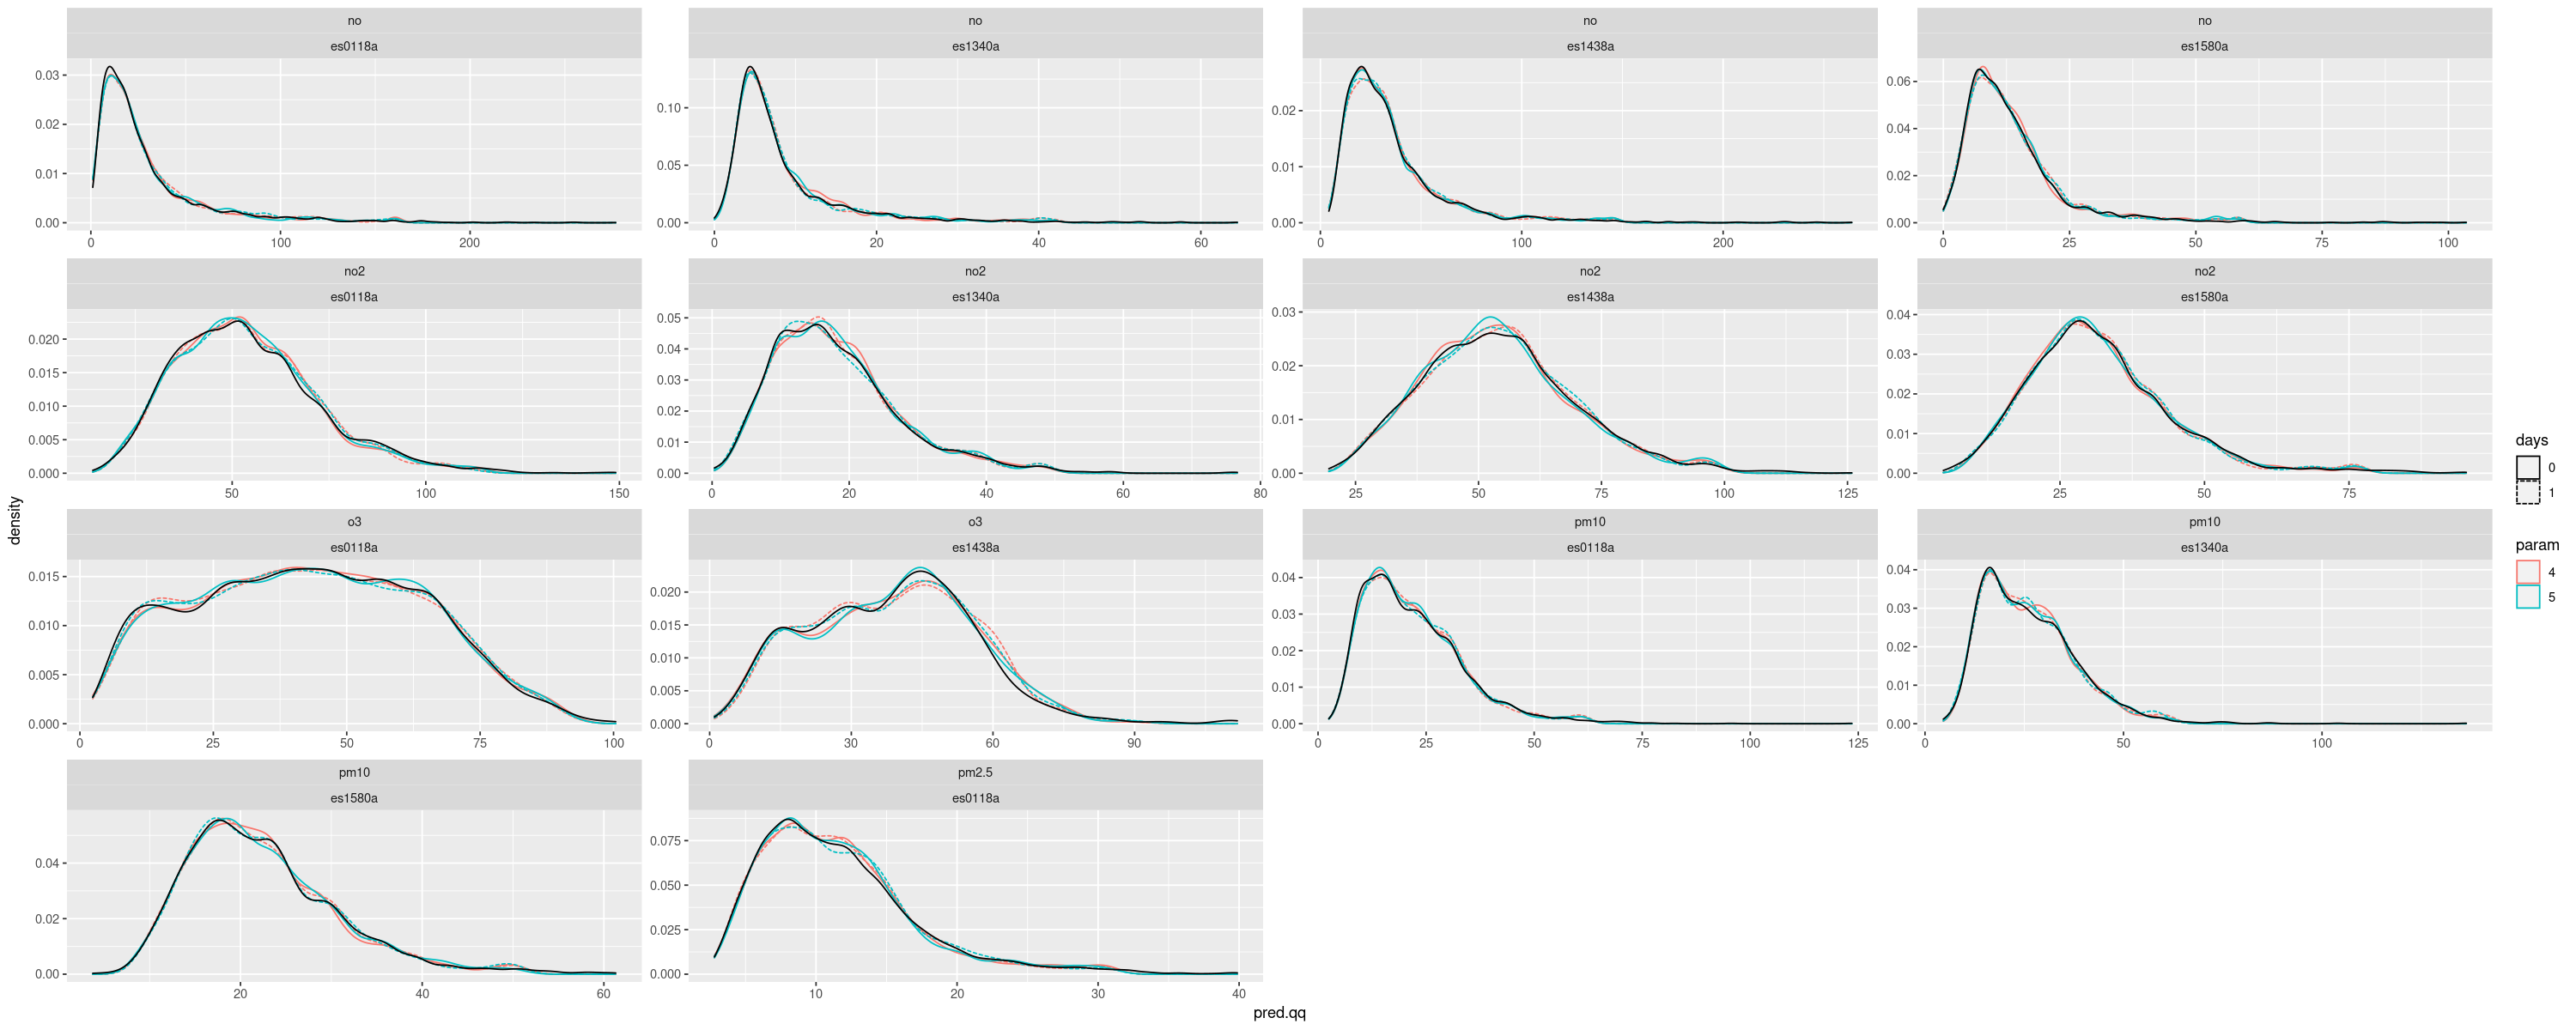

In [14]:
ggplot(data=predict.df) +
    geom_density(aes(x=pred.qq, color=param, linetype=days)) +
    geom_density(aes(x=obs), color="black") +
    facet_wrap(~variable+site, scale="free")